# ConvAge3  
Bigger SegNet architecture than ConvAge2, designed to respect the make the most out of MX150 GPU. 

In [1]:
#Created for ConvAge

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from data_utils import FaceData, FaceDataCropped
import time
import os

%load_ext autoreload
%autoreload 2
%matplotlib inline

plt.ion()   # interactive mode

In [2]:
train_data = FaceDataCropped(image_paths_file='LAG_background/train/train.txt')
val_data = FaceData(image_paths_file='LAG/val/val.txt')
test_data = FaceData(image_paths_file='LAG/train/train.txt')

Train size: 1489
Validation size: 260
Img size:  torch.Size([3, 200, 200])
Segmentation size:  torch.Size([200, 200])


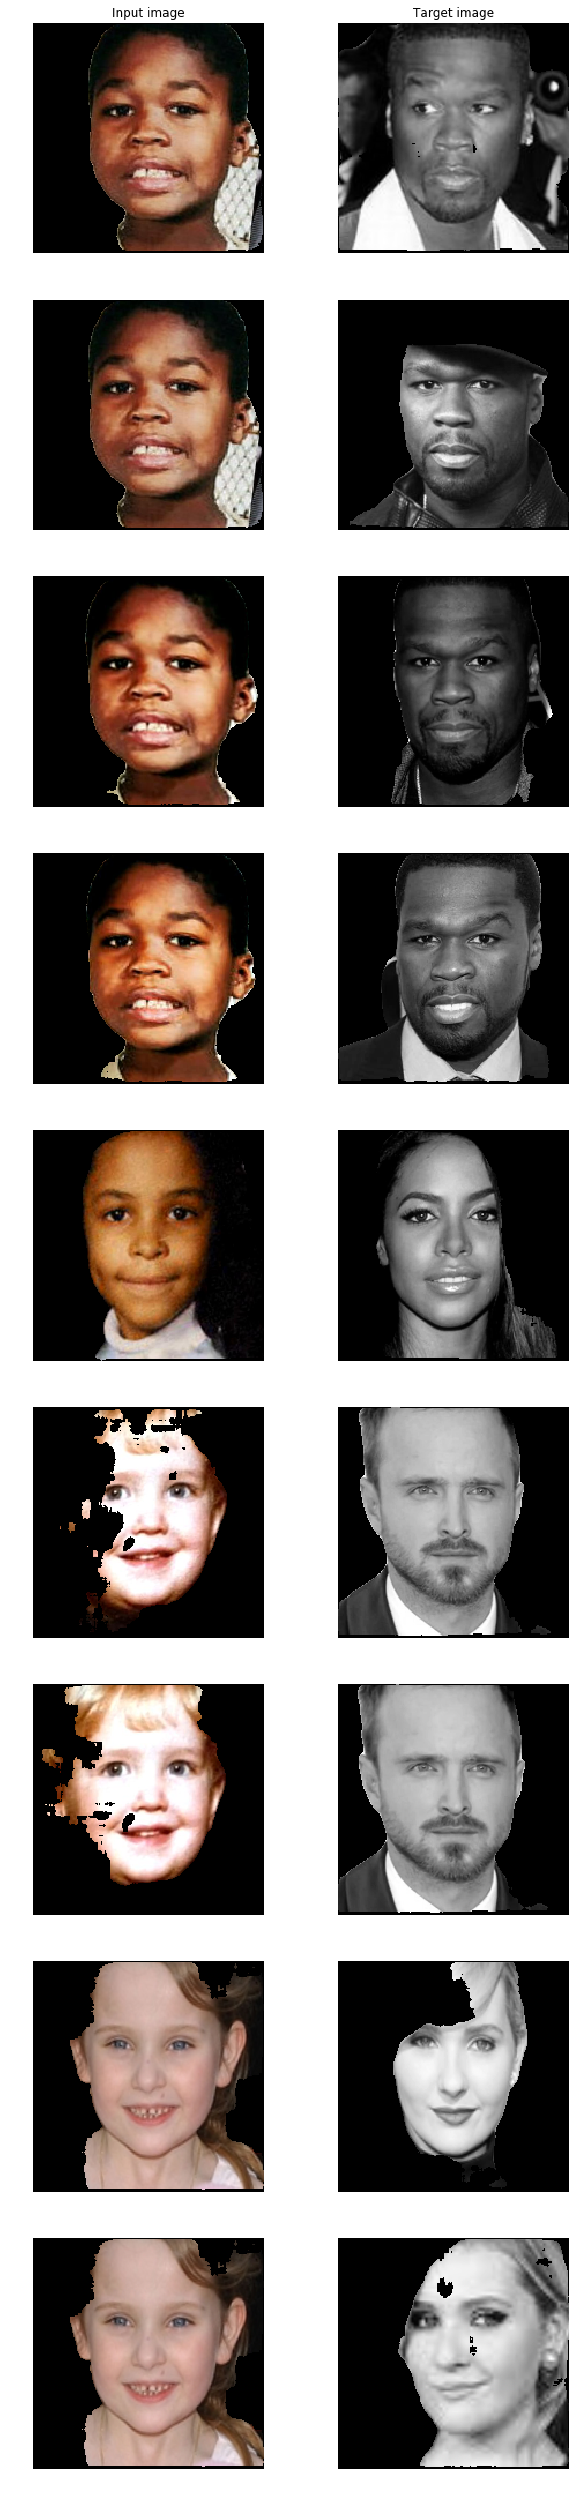

In [3]:
print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))
print("Img size: ", train_data[0][0].size())
print("Segmentation size: ", train_data[0][1].size())

num_example_imgs = 9
plt.figure(figsize=(10, 5 * num_example_imgs))
for i, (img, target) in enumerate(train_data[:num_example_imgs]):
    # img
    plt.subplot(num_example_imgs, 2, i * 2 + 1)
    plt.imshow(img.numpy().transpose(1,2,0))
    plt.axis('off')
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 2, i * 2 + 2)
    targetsc = target.numpy() / 255
    plt.imshow(targetsc.reshape(200, 200), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.title("Target image")
plt.show()

In [ ]:
from nets.convage_final import ConvAgeNN
from solver import Solver
import torch.nn.functional as F
import torchvision.models as models

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=1,
                                           shuffle=True,
                                           num_workers=1)
val_loader = torch.utils.data.DataLoader(val_data,
                                         batch_size=1,
                                         shuffle=False,
                                         num_workers=1)
#model = torch.load('models/convage_nn_3.model')
model = ConvAgeNN()
print(len(list(model.parameters())))

for param in list(model.parameters())[:20]:
    param.requires_grad = False    

solver = Solver(optim_args={"lr": 1e-3,
                            "eps": 1e-8
                            },
                loss_func = torch.nn.MSELoss(ignore_index = -1))
solver.train(model, train_loader, val_loader, log_nth=1, num_epochs=1)


import pandas as pd
save_acc_loss_dic = {'train_loss_history': solver.train_loss_history,
                     'train_acc_history' : solver.train_acc_history ,
                     'val_acc_history'   : solver.val_acc_history   ,
                     'val_loss_history'  : solver.val_loss_history   }

save_acc_loss = pd.DataFrame(data = save_acc_loss_dic)
save_acc_loss.to_csv('save_acc_loss.txt')

In [ ]:
num_example_imgs = 10
plt.figure(figsize=(15, 5 * num_example_imgs))
for i, (img, target) in enumerate(train_data[1220:1220+num_example_imgs]):
    inputs = img.unsqueeze(0)
    inputs = Variable(inputs)
    if model.is_cuda:
        inputs = inputs.cuda()
    
    outputs = model.forward(inputs)
    _, preds = torch.max(outputs, 1)
    pred = preds[0].data.cpu()
    
    img, target, pred = img.numpy(), target.numpy(), pred.numpy()
    
    # img
    plt.subplot(num_example_imgs, 3, i * 3 + 1)
    plt.axis('off')
    plt.imshow(img.transpose(1,2,0))
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 3, i * 3 + 2)
    plt.axis('off')
    target /= 255
    plt.imshow(target.reshape(200,200), cmap='gray')
    if i == 0:
        plt.title("Target image")

    # pred
    plt.subplot(num_example_imgs, 3, i * 3 + 3)
    plt.axis('off')
    plt.imshow(pred.reshape(200,200), cmap='gray')
    if i == 0:
        plt.title("Prediction image")
plt.show()

## Different nets train
Code written for testing different architectures and loss functions

In [ ]:
#imported from ConvAge3_mse
from nets.convage_final import ConvAgeNN
from solver_mse import Solver
import torch.nn.functional as F
import torchvision.models as models
import pandas as pd

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=8,
                                           shuffle=True,
                                           num_workers=8)
val_loader = torch.utils.data.DataLoader(val_data,
                                         batch_size=1,
                                         shuffle=False,
                                         num_workers=1)
#model = torch.load('models/convage_nn_3.model')
model = ConvAgeNN()
print(len(list(model.parameters())))

for param in list(model.parameters())[:20]:
    param.requires_grad = False  

solver = Solver(optim_args={"lr": 1e-4,
                            "eps": 1e-8
                            },
                loss_func = torch.nn.MSELoss())


epochsIter = 10
numInitEpochs = 0
for i in range(100):
    solver.train(model, train_loader, val_loader, log_nth=1, num_epochs=epochsIter)
    model.save('models/segnet_vgg/segnetvgg8_nobackground_' + str(numInitEpochs + (i+1) * epochsIter) + '_epochs.model')
    save_acc_loss_dic = {'train_loss_history': solver.train_loss_history,
                         'train_acc_history' : solver.train_acc_history ,
                         'val_acc_history'   : solver.val_acc_history   ,
                         'val_loss_history'  : solver.val_loss_history   }

    save_acc_loss = pd.DataFrame.from_dict(save_acc_loss_dic, orient='index')
    save_acc_loss.transpose()
    save_acc_loss.to_csv('history/segnet_vgg/segnetvgg8_nobackground_' + str(numInitEpochs + (i+1) * epochsIter) + '_epochs.txt')
    #visualize every 20 epochs
    num_example_imgs = 5
    plt.figure(figsize=(15, 5 * num_example_imgs))
    for i, (img, target) in enumerate(val_data[25:25+num_example_imgs]):
        inputs = img.unsqueeze(0)
        inputs = Variable(inputs)
        if model.is_cuda:
            inputs = inputs.cuda()
    
        outputs = model.forward(inputs)
        _, preds = torch.max(outputs, 1)
        preds = outputs[0].data.cpu()
        img, target, preds = img.numpy(), target.numpy(), preds.numpy()
        #img /= 255
        #target /= 255
        #preds /= 255
        
        
    
        # img
        plt.subplot(num_example_imgs, 3, i * 3 + 1)
        plt.axis('off')
        plt.imshow(img.transpose(1,2,0))
        if i == 0:
            plt.title("Input image")

        # target
        plt.subplot(num_example_imgs, 3, i * 3 + 2)
        plt.axis('off')
        plt.imshow(target.reshape(200,200), cmap='gray')
        if i == 0:
            plt.title("Target image")

        # pred
        plt.subplot(num_example_imgs, 3, i * 3 + 3)
        plt.axis('off')
        plt.imshow(preds.reshape(200,200), cmap='gray')
        if i == 0:
            plt.title("Prediction image")
    plt.show()